In [1]:
from __future__ import print_function
import sys
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(threshold=sys.maxsize)

import mdtraj as md
from mdtraj.geometry.alignment import compute_average_structure
import matplotlib.pyplot as plt
from itertools import combinations
from mdtraj.formats import PDBTrajectoryFile


In [2]:
construct = "7XY6_HIP"
traj_repl = [md.load('./'+construct+'-traj_centered_skip.rep_1.xtc', top='./'+construct+'-start.rep_1.gro'),
            md.load('./'+construct+'-traj_centered_skip.rep_2.xtc', top='./'+construct+'-start.rep_2.gro'),
            md.load('./'+construct+'-traj_centered_skip.rep_3.xtc', top='./'+construct+'-start.rep_3.gro'),
            ]

In [3]:
rmsd_data = []
rmsd_ligand_data = []
rmsf_data = []

In [4]:
# Compute the RMSF (*10 to go from nm to Å)
# 
for traj in traj_repl:
    
    top = traj.topology
# Next is the selectiom for A2A
    atom_selection = traj.topology.select('(protein and name CA and resi < 305)')
# Next is the selectiom for ligand
    atom_selection_lig = traj.topology.select('(resn L01)')
# Align frames
    traj_al = traj.superpose(traj,frame=0, atom_indices=atom_selection)
# Tana uses everything since pymemdyn 5ns before 100ns
    used_frames = traj_al[0:100]
# Compute the average structure
    average_xyz = np.mean(used_frames.xyz, axis=0)
    average_structure = md.Trajectory(average_xyz, top)
#
# RMSF A2A
#
# rmsf = md.rmsf(used_frames, traj, 0, atom_indices=atom_selection) * 10, but Florian formula
    rmsf_a2a = np.sqrt( 3 * np.mean( (used_frames.atom_slice(atom_selection).xyz - average_structure.atom_slice(atom_selection).xyz)**2, axis=(0, 2) ) ) * 10
    rmsf_data.append(rmsf_a2a)
#
# RMSD of the whole protein
#
#   rmsd = md.rmsd(traj, traj, 0, atom_indices=atom_selection) * 10 
#
    rmsd = md.rmsd(used_frames, used_frames, 0, atom_indices=atom_selection) * 10 
    rmsd_data.append(rmsd)

# RMSD of the ligand
#    
    rmsd_lig = md.rmsd(used_frames, used_frames, 0, atom_indices=atom_selection_lig) * 10 
    rmsd_ligand_data.append(rmsd_lig)  
#
##  End of loop ###########

In [5]:
# Calculate the mean RMSF 
rmsf = np.vstack(rmsf_data)
mean_rmsf = np.mean(rmsf, axis=0)
# Calculate the mean RMSD values for each residue
rmsd = np.vstack(rmsd_data)
mean_rmsd = np.mean(rmsd, axis=0)
rmsd_ligand = np.vstack(rmsd_ligand_data)
mean_rmsd_ligand = np.mean(rmsd_ligand, axis=0)
# Write in separate columns as independent files
#output_rmsf = "./ANALYSIS/"+construct+"/rmsf_a2a_"+construct+"_ave.dat"
#with open(output_rmsf_a2a, 'w') as f:
  #  for value in mean_rmsf:
     #   f.write(f'{value}\n')   
#
#output_rmsd = "./ANALYSIS/"+construct+"/rmsd_a2a_"+construct+"_ave.dat"
#with open(output_rmsd, 'w') as x:
    #for value in mean_rmsd:
       # x.write(f'{value}\n')
#
#output_rmsd_lig = "./ANALYSIS/"+construct+"/rmsd_lig_"+construct+"_ave.dat"
#with open(output_rmsd, 'w') as x:
    #for value in mean_rmsd_ligand:
       # x.write(f'{value}\n')

In [6]:
#transfer to pandas for seaborn

# Create a DataFrame with labels 1 to number of replica)

# Create a DataFrame with columns named 1 to x (x = number of arrays)
#RMSD
df_rmsd = pd.DataFrame([arr.tolist() for arr in rmsd_data])
df_rmsd.index = range(1,len(rmsd_data)+1)
df_rmsd = df_rmsd.transpose()
df_rmsd['Time (ns)'] = df_rmsd.index
df_rmsd['Average'] = mean_rmsd  
average_std = df_rmsd['Average'].std() 

# Create a DataFrame with columns named 1 to x (x = number of arrays)
#RMSD - ligand
df_rmsd_ligand = pd.DataFrame([arr.tolist() for arr in rmsd_ligand_data])
df_rmsd_ligand.index = range(1,len(rmsd_data)+1)
df_rmsd_ligand = df_rmsd_ligand.transpose()
df_rmsd_ligand['Time (ns)'] = df_rmsd_ligand.index
df_rmsd_ligand['Average'] = mean_rmsd_ligand  
average_std = df_rmsd_ligand['Average'].std() 

#RMSF
df_rmsf = pd.DataFrame([arr.tolist() for arr in rmsf_data])
df_rmsf.index = range(1,len(rmsf_data)+1)
df_rmsf = df_rmsf.transpose()
df_rmsf['Residue index'] = df_rmsf.index
df_rmsf['Average'] = mean_rmsf



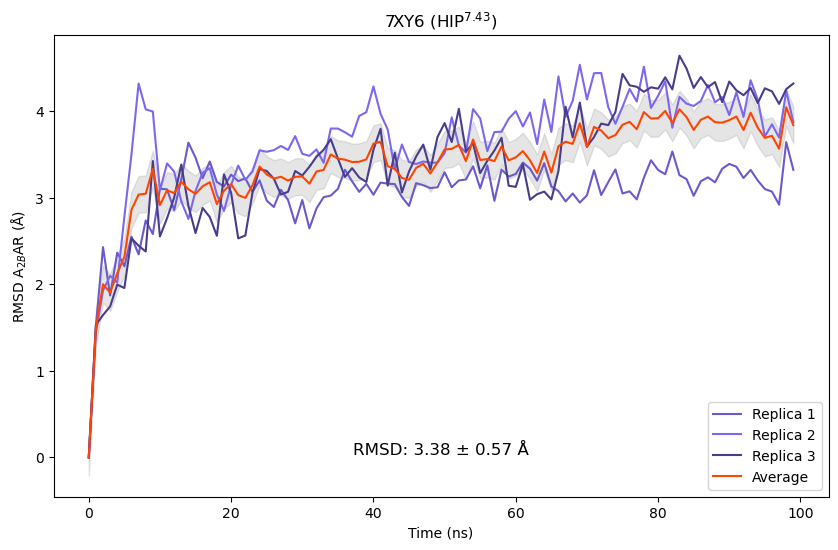

In [80]:
#RMSD plot
#Average + standard deviation
average_of_averages = df_rmsd['Average'].mean()
std_of_averages = df_rmsd['Average'].std()

plt.figure(figsize=(10,6))
ax = sns.lineplot(data=df_rmsd, x='Time (ns)', y=1, label='Replica 1', color='slateblue')
sns.lineplot(data=df_rmsd, x='Time (ns)', y=2, label = 'Replica 2', color='mediumslateblue')
sns.lineplot(data=df_rmsd, x='Time (ns)', y=3, label = 'Replica 3', color='darkslateblue')
sns.lineplot(data=df_rmsd, x='Time (ns)', y='Average', label = 'Average', color='orangered')
plt.fill_between(df_rmsd['Time (ns)'], df_rmsd['Average'] - average_std, df_rmsd['Average'] + average_std, alpha=0.2,color='grey')
plt.title('7XY6 (HIP$^{7.43}$)')
plt.ylabel('RMSD A$_{2B}$AR (Å)')
plt.legend(loc='lower right', fontsize='10')

# average RMSD
ax.text(0.5, 0.1, f'RMSD: {average_of_averages:.2f} ± {std_of_averages:.2f} Å', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.0))

plt.savefig('RMSD_'+construct+'.png',dpi=300)
plt.show()

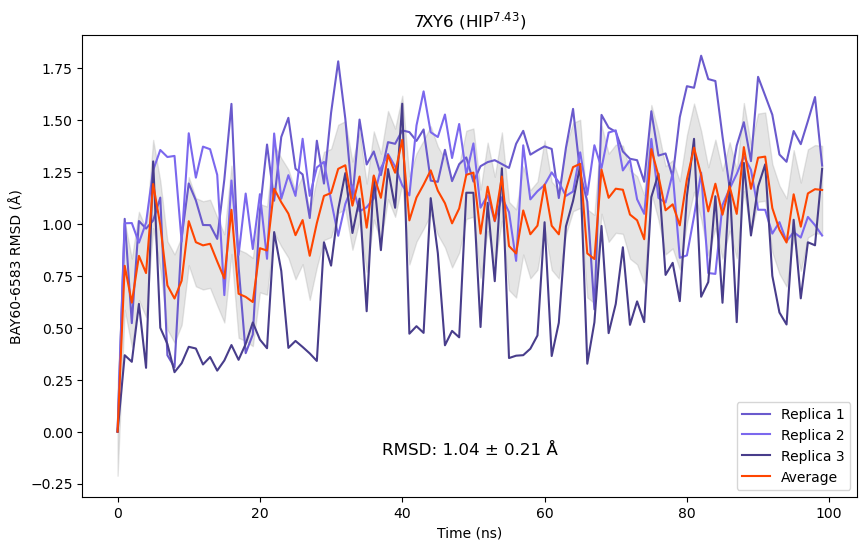

In [83]:
#RMSD plot - ligand

#Average + standard deviation
average_of_averages = df_rmsd_ligand['Average'].mean()
std_of_averages = df_rmsd_ligand['Average'].std()

plt.figure(figsize=(10,6))
ax = sns.lineplot(data=df_rmsd_ligand, x='Time (ns)', y=1, label='Replica 1', color='slateblue')
sns.lineplot(data=df_rmsd_ligand, x='Time (ns)', ax=ax, y=2, label = 'Replica 2', color='mediumslateblue')
sns.lineplot(data=df_rmsd_ligand, x='Time (ns)', ax=ax, y=3, label = 'Replica 3', color='darkslateblue')
sns.lineplot(data=df_rmsd_ligand, x='Time (ns)', ax=ax, y='Average', label = 'Average', color='orangered')
plt.fill_between(df_rmsd['Time (ns)'], df_rmsd_ligand['Average'] - average_std, df_rmsd_ligand['Average'] + average_std, alpha=0.2, color='grey')
plt.title('7XY6 (HIP$^{7.43}$)')
plt.ylabel('BAY60-6583 RMSD (Å)')
plt.legend(loc='lower right', fontsize='10')

# Add text annotation for average of the 'Average' series and standard deviation
ax.text(0.5, 0.1, f'RMSD: {average_of_averages:.2f} ± {std_of_averages:.2f} Å', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.0))

plt.savefig('RMSD_'+construct+'_ligand.png',dpi=300)
plt.show()

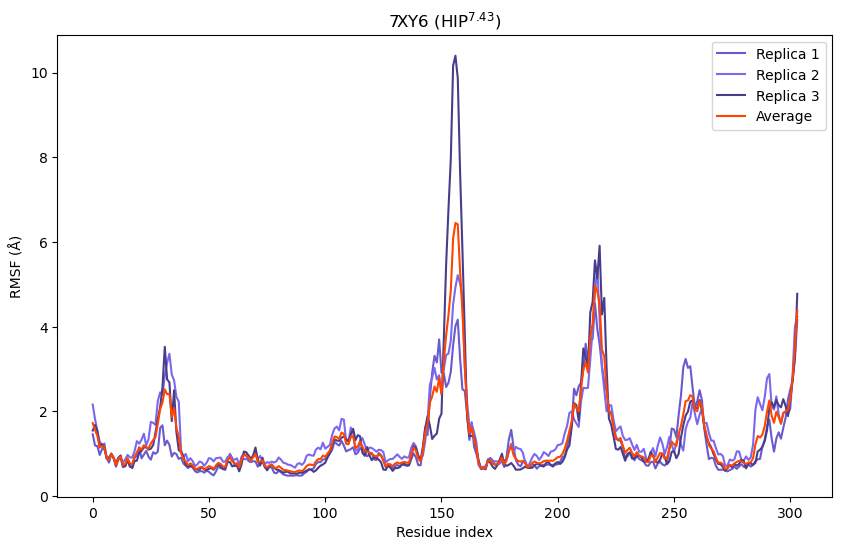

In [84]:
#RMSF plot
plt.figure(figsize=(10,6))
sns.lineplot(data=df_rmsf, x='Residue index', y=1, label = 'Replica 1', color ='slateblue')
sns.lineplot(data=df_rmsf, x='Residue index', y=2, label = 'Replica 2', color ='mediumslateblue')
sns.lineplot(data=df_rmsf, x='Residue index', y=3, label = 'Replica 3', color ='darkslateblue')
sns.lineplot(data=df_rmsf, x='Residue index', y='Average', label = 'Average', color ='orangered')
plt.title('7XY6 (HIP$^{7.43}$)')
plt.ylabel('RMSF (Å)')
plt.savefig('RMSF_'+construct+'.png',dpi=300)
plt.show()